<a href="https://colab.research.google.com/github/Eric-Chung-0511/Learning-Record/blob/main/General%20Helpers/PyTorch/Experiments/PyTorch_Model_Deployment_FoodVision_mini_Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get the data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

## FoodVision Mini model deployment experiment outline

* **Performance** - A model that performs at 95%+ accuracy.
* **Speed** - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).

## Creating an EffNetB2 feature extractor

In [ ]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transform = effnetb2_weights.transforms()

# setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# freeze the base layers in the model
for parameter in effnetb2.parameters():
    parameter.requires_grad = False

In [ ]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1408,
              out_features=3)  # change out_features to suit our number of classes
)

### Creating a function to make an EffNetB2 feature extractor

In [ ]:
def create_effnetb2_model(num_classes=3):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transform = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # freeze the layers
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1408,
                  out_features=num_classes)
    )
    return model, transform

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Creating DataLoaders for EffNetB2

In [ ]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_nams = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                test_dir=test_dir,
                                                                                                transform=effnetb2_transforms,
                                                                                                batch_size=32)


### Training EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9860 | train_acc: 0.5146 | test_loss: 0.7318 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.7210 | train_acc: 0.8229 | test_loss: 0.5749 | test_acc: 0.9563
Epoch: 3 | train_loss: 0.5941 | train_acc: 0.8542 | test_loss: 0.5043 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4496 | train_acc: 0.9125 | test_loss: 0.4327 | test_acc: 0.9625
Epoch: 5 | train_loss: 0.4508 | train_acc: 0.8729 | test_loss: 0.3929 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.4028 | train_acc: 0.8729 | test_loss: 0.3598 | test_acc: 0.9625
Epoch: 7 | train_loss: 0.3376 | train_acc: 0.9208 | test_loss: 0.3411 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.3624 | train_acc: 0.9146 | test_loss: 0.3201 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3645 | train_acc: 0.9021 | test_loss: 0.3003 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.3203 | train_acc: 0.8917 | test_loss: 0.2923 | test_acc: 0.9750


###  Inspecting EffNetB2 loss curves

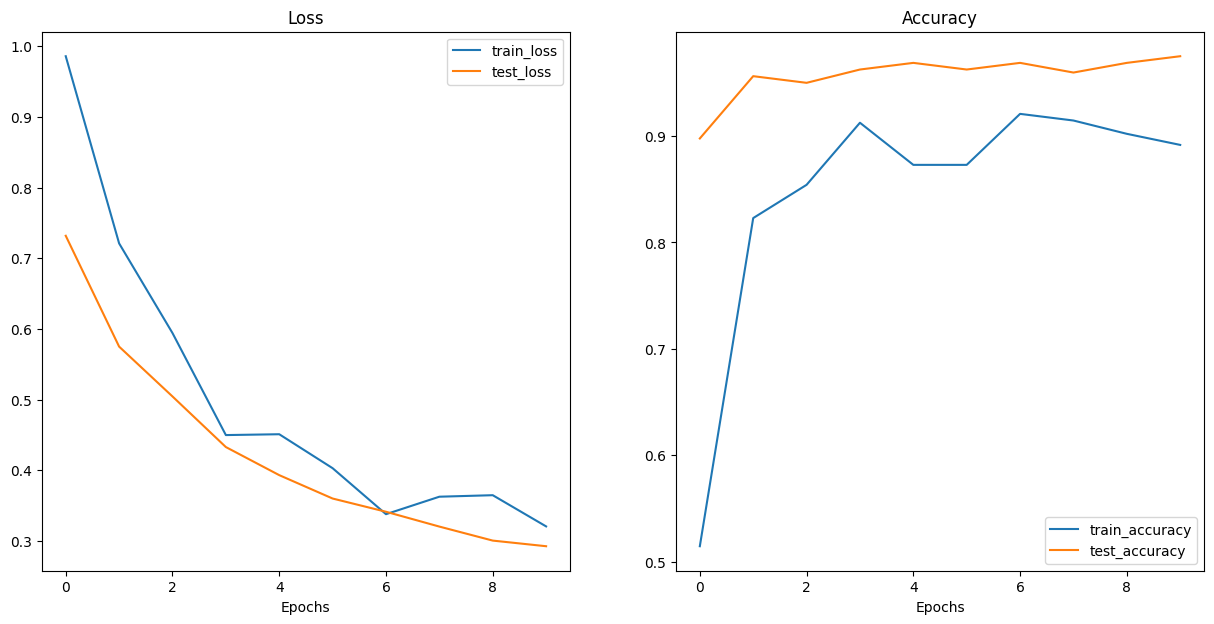

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

### Saving EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name='pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### Checking the size of EffNetB2 feature extractor

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path('models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())

effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                  'test_acc': effnetb2_results['test_acc'][-1],
                  'number_of_parameters': effnetb2_total_params,
                  'model_size(MB)': pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.2922943413257599,
 'test_acc': 0.975,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29}

## Creating a ViT feature extractor

In [ ]:
# check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes=3):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transform = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # freeze all layers in model
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))

    return model, transform

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3)

In [ ]:
from torchinfo import summary

# Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Create DataLoaders for ViT

In [ ]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### Training ViT feature extractor

In [ ]:
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5943 | train_acc: 0.7917 | test_loss: 0.2345 | test_acc: 0.9375
Epoch: 2 | train_loss: 0.2163 | train_acc: 0.9396 | test_loss: 0.1195 | test_acc: 0.9750
Epoch: 3 | train_loss: 0.1456 | train_acc: 0.9604 | test_loss: 0.0911 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1206 | train_acc: 0.9646 | test_loss: 0.0791 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.1334 | train_acc: 0.9375 | test_loss: 0.0689 | test_acc: 0.9875
Epoch: 6 | train_loss: 0.0873 | train_acc: 0.9750 | test_loss: 0.0673 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0749 | train_acc: 0.9833 | test_loss: 0.0600 | test_acc: 0.9875
Epoch: 8 | train_loss: 0.0661 | train_acc: 0.9875 | test_loss: 0.0574 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0577 | train_acc: 0.9938 | test_loss: 0.0570 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0601 | train_acc: 0.9938 | test_loss: 0.0545 | test_acc: 0.9875


### Inspecting ViT loss curves

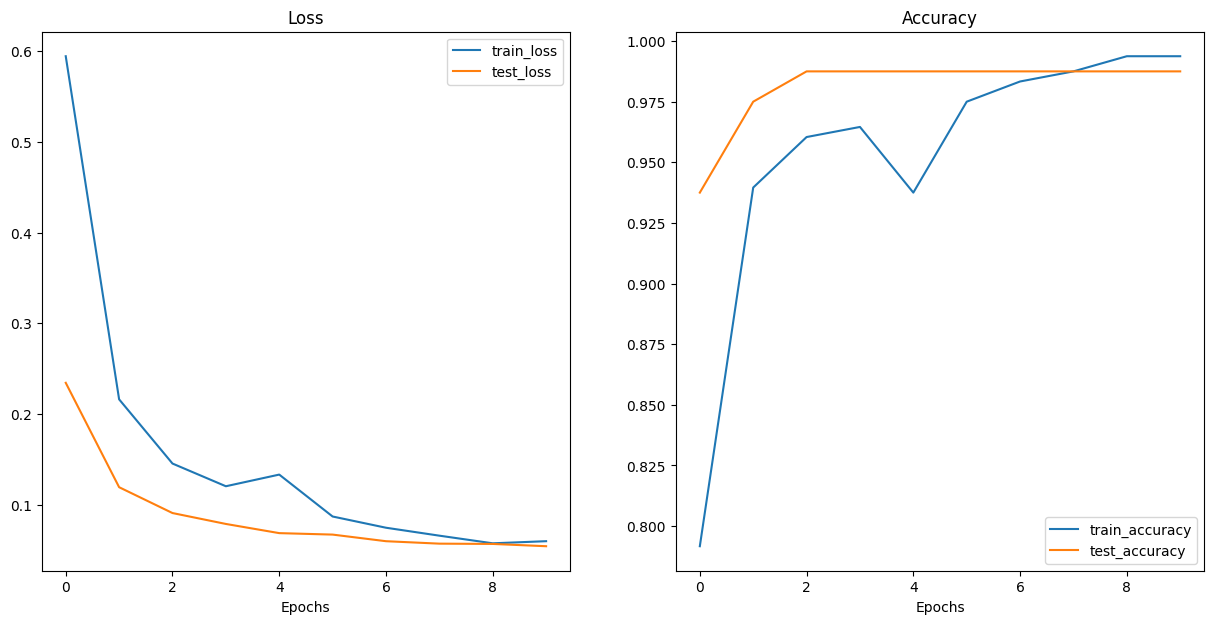

In [ ]:
plot_loss_curves(vit_results)

In [ ]:
utils.save_model(model=vit,
                 target_dir='models',
                 model_name='pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### Collecting ViT feature extractor stats

In [ ]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size(MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.0545222285669297,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327}

## Making predictions with our trained models and timing them

In [ ]:
# get all test data paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/44810.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg')]

### Creating a function to make across the test dataset

### 建立一個函數，它接受以下參數：
**測試模型的準確度與速度**
- 一個包含路徑的列表
- 一個訓練好的 PyTorch 模型
- 一系列用於處理圖像的變換
- 目標類別名稱的列表
- 目標設備（如 CPU 或 GPU）

### 步驟：

1. 建立一個函數，該函數接收上面提到的參數。

2. 創建一個空的列表，用於存儲預測字典（我們希望這個函數返回一個包含字典的列表，每個字典對應一個預測結果）。

3. 遍歷目標輸入路徑（步驟 4-14 將在這個循環內完成）。

4. 在循環的每次迭代中，為每個樣本創建一個空的字典，以存儲該樣本的預測值。

5. 獲取樣本路徑和真實類別名稱（我們可以通過從路徑推斷出類別名稱來實現）。

6. 使用 Python 的 `timeit.default_timer()` 啟動預測計時器。

7. 使用 `PIL.Image.open(path)` 打開圖像。

8. 轉換圖像，使其能夠與目標模型一起使用，並添加批次維度，然後將圖像發送到目標設備。

9. 將模型發送到目標設備，並進入 `eval()` 模式，為推理做好準備。

10. 使用 `torch.inference_mode()`，將目標轉換後的圖像傳遞給模型，並使用 `torch.softmax()` 計算預測概率，使用 `torch.argmax()` 獲取目標標籤。

11. 將預測概率和預測類別添加到步驟 4 中創建的預測字典中。還要確保預測概率位於 CPU 上，這樣可以與非 GPU 的庫（如 NumPy 和 pandas）一起使用，以便後續檢查。

12. 結束在步驟 6 中啟動的預測計時器，並將時間添加到步驟 4 中創建的預測字典中。

13. 查看預測類別是否與步驟 5 中的真實類別相符，並將結果添加到步驟 4 中創建的預測字典中。

14. 將更新後的預測字典附加到步驟 2 中創建的空預測列表中。

15. 返回預測字典列表。


In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths, model, transform, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name, stem is final bit, like steak
        pred_dict['image_path'] = path
        class_name = path.parent.stem
        pred_dict['class_name'] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device, because it's for the model
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_probs = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_probs, dim=1)
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU, python variables live on cpu

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict['pred_prob'] = round(pred_probs.unsqueeze(0).max().cpu().item(), 4) # only want the biggest probs
            pred_dict['pred_class'] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict['time_for_pred'] = round(end_time - start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict['correct'] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

## Making and timing predictions with EffNetB2

* **Device** - We'll hard code the `device` parameter to use `"cpu"` because when we deploy our model, we won't always have access to a `"cuda" (GPU)` device.
Making the predictions on `CPU` will be a good indicator of speed of inference too because generally predictions on `CPU` devices are slower than`GPU` devices.

* **Transforms** - We'll also be sure to set the transform parameter to effnetb2_transforms to make sure the images are opened and transformed in the same way our `effnetb2 model` has been trained on.

In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device='cpu') # make predictions on cpu

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9859,
  'pred_class': 'pizza',
  'time_for_pred': 0.1481,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8421,
  'pred_class': 'pizza',
  'time_for_pred': 0.1102,
  'correct': True}]

In [ ]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9859,pizza,0.1481,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8421,pizza,0.1102,True
2,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.5543,pizza,0.0888,True
3,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.8537,pizza,0.1000,True
4,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9371,pizza,0.0951,True


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df['correct'].value_counts()

,count
correct,
True,146
False,4


In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df['time_for_pred'].mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0966 seconds


In [ ]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2922943413257599,
 'test_acc': 0.975,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29,
 'time_per_pred_cpu': 0.0966}

## Making and timing predictions with ViT

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9974,
  'pred_class': 'pizza',
  'time_for_pred': 0.6969,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9985,
  'pred_class': 'pizza',
  'time_for_pred': 0.3724,
  'correct': True}]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9974,pizza,0.6969,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9985,pizza,0.3724,True
2,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9968,pizza,0.3723,True
3,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9962,pizza,0.3839,True
4,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9992,pizza,0.3850,True


In [ ]:
vit_test_pred_df['correct'].value_counts()

,count
correct,
True,148
False,2


In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df['time_for_pred'].mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4193 seconds


In [ ]:
# Add average prediction time for ViT model on CPU
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.0545222285669297,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327,
 'time_per_pred_cpu': 0.4193}

## Comparing model results, prediction times and size

In [ ]:
#  turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column name
df['model'] = ['EffNetB2', 'VIT']

# convert accuracy to percentages
df['test_acc'] = round(df['test_acc'] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size(MB),time_per_pred_cpu,model
0,0.292294,97.50,7705221,29,0.0966,EffNetB2
1,0.054522,98.75,85800963,327,0.4193,VIT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index('model').loc['VIT'] / df.set_index('model').loc['EffNetB2']),
             columns=['VIT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parameters,model_size(MB),time_per_pred_cpu
VIT to EffNetB2 ratios,0.186532,1.012821,11.135432,11.275862,4.34058


## Visualizing the speed vs. performance tradeoff

mkdir: cannot create directory ‘images/’: File exists


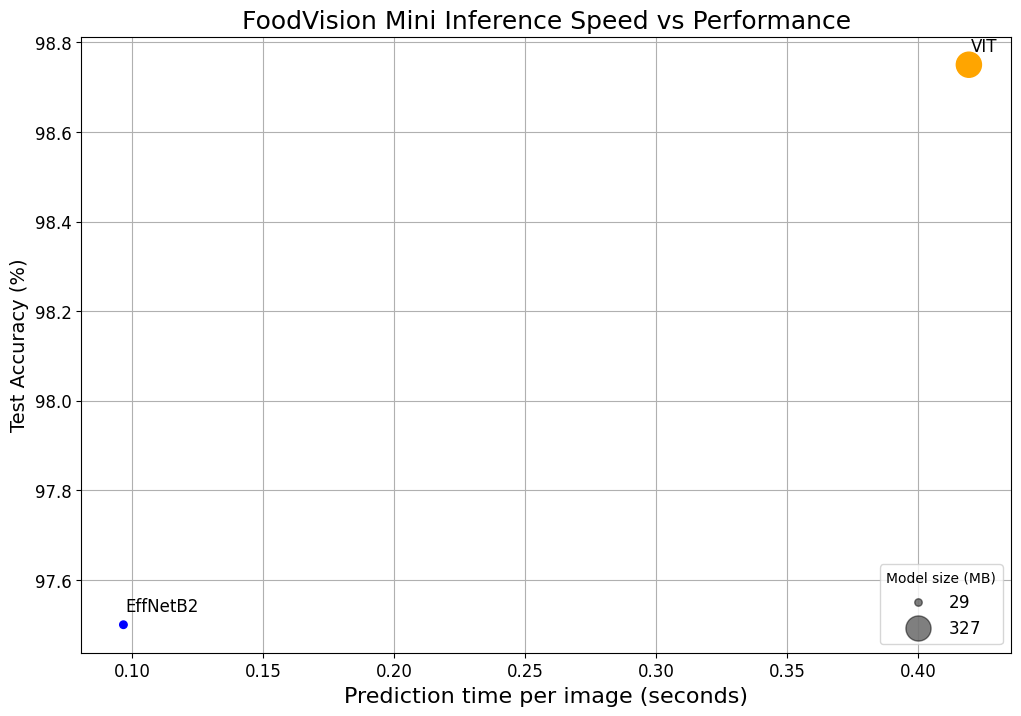

In [ ]:
# Create a plot fro, model coparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x='time_per_pred_cpu',
                     y='test_acc',
                     c=['blue', 'orange'], # color
                     s='model_size(MB)') # sizes

# Add title and labels
ax.set_title('FoodVision Mini Inference Speed vs Performance', fontsize=18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=16)
ax.set_ylabel('Test Accuracy (%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# Annotate the samples on the scatter plot, ax.annotate:在圖表特定位置添加文本
for index, row in df.iterrows():
    ax.annotate(text=row['model'],
                xy=(row['time_per_pred_cpu']+0.0006, row['test_acc']+0.03), # first=x, second=y
                size=12)

# Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legned = ax.legend(handles,
                              labels,
                              loc='lower right',
                              title='Model size (MB)',
                              fontsize=12)

# Save the figure
!mkdir images/
plt.savefig('images/foodvision-mini-inference-speed-vs-performance.jpg')

plt.show()

## Bringing FoodVision Mini to life by creating a Gradio demo

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 4.42.0


### Creating a function to map our inputs and outputs

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

In [ ]:
# put our model on the CPU
effnetb2 = effnetb2.to('cpu')

# check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

* `pred_probs` 的形狀通常是 [batch_size, num_classes]
    * `batch_size` 是批次大小，即一次性輸入模型的圖像數量。
    * `num_classes` 是分類的數量，例如，如果有 3 個類別（cat、dog、bird），那麽 num_classes 就是 3。

* `pred_probs[0][i]` 提取了第 i 個類別的預測概率。
    * 如果 i = 0，則 pred_probs[0][0] 表示模型預測第一個類別（例如 cat）的概率。
    * 如果 i = 1，則 pred_probs[0][1] 表示模型預測第二個類別（例如 dog）的概率。


* `pred_probs[0]`：表示模型對第一個圖像的所有類別的預測概率。
* `pred_probs[0][i]`：表示模型對第一個圖像的第 i 個類別的預測概率。

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    # start a timer
    start_time = timer()

    # transform the input image for use with EffNetB2, unsqueeze to fit the model
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
         # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
         pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return pred dict and pred_time
    return pred_labels_and_probs, pred_time

In [ ]:
# test function
import random

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

# randomly select test image path, k=1隨機抽取一個元素
# [0]代表從列表中直接提取出路徑字符串，而不是一個包含路徑的列表。
random_image_path = random.sample(test_data_paths, k=1)[0]

# open the image
image = Image.open(random_image_path)
print(f'[INFO] Predicting on image at path: {random_image_path}\n')

# predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg

{'pizza': 0.03427769988775253, 'steak': 0.04785390570759773, 'sushi': 0.917868435382843}
0.09267


### Creating a list of example images

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/705150.jpg']]

### Building a Gradio interface

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

In [ ]:
import gradio as gr

# create title, description, article
title = 'FoodVision Mini 🍕🥩🍣'
description = 'An [EfficientNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify images of food as pizza, steak or sushi.'
article = 'PyTorch Model Deployment'

# create the gradio demo
demo = gr.Interface(fn=predict, # the predict function
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                    gr.Number(label='Prediction time (s)')], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the model
demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6830001f5dbd74962d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Turning our FoodVision Mini Gradio Demo into a deployable app

```
demos/
└── foodvision_mini/
    ├── pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```


### Creating a demos folder to store our FoodVision Mini app files

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

else:
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

!ls demos/foodvision_mini/

### Creating a folder of example images to use with our FoodVision Mini demo

In [ ]:
import shutil

# create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / 'examples'
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three images test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# copy the three images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f'[INFO] Copying {example} to {destination}')
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
# 因為圖片在Examples階層裡 是第二個階層 所以要創一個路徑在Examples裡面
import os

# get example filepath in a list of lists
example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

### Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# create a destination path for target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split('/')[1]

# move the model file
try:
    print(print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}"))

    # move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f'[INFO] Model move complete.')

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
None
[INFO] Model move complete.


### Turning our EffNetB2 model into a Python script `(model.py)`

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


### Turning our FoodVision Mini Gradio app into a Python script `(app.py)`

In [ ]:
%%writefile demos/foodvision_mini/app.py

import gradio as gt
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# setup class names
class_names = ['pizza', 'steak', 'suhsi']

# model and transforms preparation
# create effnetb2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
               map_location=torch.device('cpu')) # load to CPU
)

# Predict function
def predict(img):
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

### Gradio app ###
title = 'FoodVision Mini 🍕🥩🍣'
description = 'An [EfficientNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify images of food as pizza, steak or sushi.'
article = 'PyTorch Model Deployment'

example_list = [[os.path.join('examples', example)] for example in os.listdir('examples')]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")], # function has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Overwriting demos/foodvision_mini/app.py


### Creating a requirements file for FoodVision Mini `(requirements.txt)`

* This will be a text file containing all of the required dependencies for our demo.

* torch: 2.3.1+cu121
* torchvision: 0.18.1+cu121
* gradio: 4.42.0

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.3.1
torchvision==0.18.0
gradio==4.42.0

Writing demos/foodvision_mini/requirements.txt


## Deploying our FoodVision Mini app to HuggingFace Spaces

### Downloading our FoodVision Mini app files

In [ ]:
!ls demos/foodvision_mini

app.py	  model.py								  requirements.txt
examples  pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth



- `zip` 代表 "壓縮"，意思是“請將以下目錄中的文件壓縮在一起”。

- `-r` 代表 "遞歸"，意思是“遍歷目標目錄中的所有文件”。

- `../foodvision_mini.zip` 是我們希望將文件壓縮到的目標目錄。

- `*` 代表“當前目錄中的所有文件”。

- `-x` 代表“排除這些文件”。

In [ ]:
# change inot the foodvision_mini directory and the zip together
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x '*.pyc' '*.ipynb' '*__pycache__*' '*ipynb_checkpoints*'

  adding: app.py (deflated 53%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


In [ ]:
# Download
try:
    from google.colab import files
    files.download('demo/foodvision_mini.zip')
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

Not running in Google Colab, can't use google.colab.files.download(), please manually download.


### Uploading to Hugging Face